# Construction of the network

In [1]:
import csv
import pandas as pd
from collections import Counter
from itertools import permutations
from itertools import combinations
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import networkx as nx

In [2]:
file_movies = 'title.basics.tsv/title.basics.tsv'
movies = pd.read_csv(file_movies, sep='\t', na_values='\\N', dtype={
    'tconst': 'str',
    'titleType': 'str',
    'primaryTitle': 'str',
    'startYear': 'Int64',
}, usecols=['tconst', 'titleType', 'primaryTitle', 'startYear']).set_index('tconst')

In [3]:
movies = movies[(movies['startYear'] >= 1923) & (movies['titleType'] == 'movie')] 
del movies['titleType']

In [4]:
file_cast = 'title.principals.tsv/title.principal.tsv'
cast = pd.read_csv(file_cast, sep='\t', na_values='\\N', dtype={
    'tconst': 'str',
    'nconst': 'str',
    'category': 'str',
}, usecols=['tconst', 'nconst', 'category'])

In [5]:
cast = cast[cast.category.isin({'actor', 'actress'}) & cast['tconst'].isin(movies.index)]
cast.reset_index(drop=True, inplace=True)

In [57]:
file_name='name.basics.tsv/name.basics.tsv'
name = pd.read_csv(file_name, sep='\t', na_values='\\N', dtype={
    'nconst': 'str',
    'primaryName': 'str',
    'birthYear': 'Int64'
}, usecols=['nconst', 'primaryName', 'birthYear']).set_index('nconst')

Creation of the network

In [7]:
#we create a bipartite network:
B = nx.Graph()

actors = cast['nconst'].unique()
movies = movies.index.unique()

B.add_nodes_from(actors, bipartite=0)  # Actors belong to set 0
B.add_nodes_from(movies, bipartite=1)  # Movies belong to set 1


for _, row in cast.iterrows():
    actor = row['nconst']
    movie = row['tconst']
    B.add_edge(actor, movie)

In [61]:
print("Number of Actors:", len(actors))
print("Number of Movies:", len(movies))

Number of Actors: 687423
Number of Movies: 563461


In [ ]:
B.number_of_edges()

In [9]:
proj_actors= bipartite.projected_graph(B, actors)

In [10]:
nx.is_connected(proj_actors)

False

In [11]:
conn_comp=[len(c) for c in sorted(nx.connected_components(proj_actors), key=len, reverse=True)]

In [12]:
largest_cc = max(nx.connected_components(proj_actors), key=len)

In [13]:
A = proj_actors.subgraph(largest_cc)

In [14]:
A.number_of_nodes()

521964

In [16]:
A.number_of_edges()

3012174

# Centrality measures

In [18]:
import time
start = time.time()
D = nx.degree_centrality(A)
end = time.time()
print("Time taken =", end-start, "seconds")

Time taken = 8.164932250976562 seconds


In [59]:
sorted_nodes = sorted(D.items(), key=lambda x: x[1], reverse=True)
for i in range(10): 
    actor_id, centrality = sorted_nodes[i]
    name_actor=get_name_actor(actor_id)
    print(name_actor,'with degree',centrality)

Brahmanandam with degree 0.0017951463992658483
Eric Roberts with degree 0.001672532344246623
Ron Jeremy with degree 0.0014886112617177847
Eddie Garcia with degree 0.0014637052817920045
Masayoshi Nogami with degree 0.0014196408557694703
Shakti Kapoor with degree 0.0012702049762147892
Turgut Özatay with degree 0.0012702049762147892
Paquito Diaz with degree 0.00124913068550836
Mithun Chakraborty with degree 0.0012318880840212812
Master Bhagwan with degree 0.0011801602795600454


In [60]:
start = time.time()
BC = nx.betweenness_centrality(A, k=1000) 
end = time.time()

Time taken = 52208.20053887367 seconds
Brahmanandam
Eric Roberts
Ron Jeremy
Eddie Garcia
Masayoshi Nogami
Shakti Kapoor
Turgut Özatay
Paquito Diaz
Mithun Chakraborty
Master Bhagwan


In [63]:
btw_sorted= sorted(BC.items(), key=lambda item: item[1], reverse=True)
for i in range(10): 
    actor_id, btw_centrality = btw_sorted[i]
    #actor_name = get_name(actor_id)
    name_actor=get_name_actor(actor_id)
    print(name_actor,'with betweenness centrality',btw_centrality)

Eric Roberts with degree 0.048288455723391965
Michael Madsen with degree 0.016994828012109223
John Savage with degree 0.012934804664746115
Gulshan Grover with degree 0.012867073996874734
Ron Jeremy with degree 0.011515190251579365
Tom Sizemore with degree 0.011303828389304615
Franco Nero with degree 0.010683564721623427
Anupam Kher with degree 0.009828306807125256
Om Puri with degree 0.008503460918482557
Tony Devon with degree 0.008490679169494099


In [ ]:
V = [btw_sorted[i][0] for i in range(len(btw_sorted))]
clos_centr = {}
start = time.time()
for i in range(1000):
    clos_centr[V[i]] = nx.closeness_centrality(A, clos_centr[i])
end = time.time()
print("Time taken =", end-start, "seconds")
cc_sorted = sorted(clos_centr.items(), key=lambda item: item[1], reverse=True)
for i in range(5): print(cc_sorted[i][0], ":", L[i][1])

In [ ]:
for i in range(10): 
    actor_id, clos_centrality = cc_sorted[i]
    #actor_name = get_name(actor_id)
    name_actor=get_name_actor(actor_id)
    print(name_actor,'with betweenness centrality',clos_centrality)

# Community structure

Clustering coefficient

In [65]:
clus_coeff = nx.clustering(A)

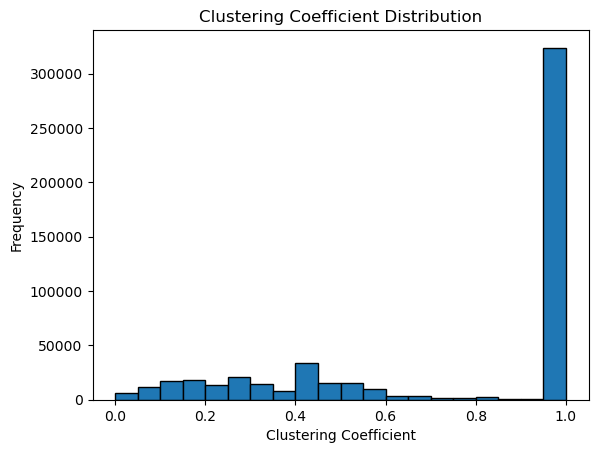

In [66]:
plt.hist(list(clus_coeff.values()), bins=20, edgecolor='k')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')
plt.title('Clustering Coefficient Distribution')
plt.show()

# Community detection

In [68]:
start = time.time()
louvain_communities=nx.community.louvain_communities(A)
end = time.time()
print("Time taken =", end-start, "seconds")

Time taken = 356.7162961959839 seconds


In [ ]:
start = time.time()
cnm_communities=nx.community.greedy_modularity_communities(A)
end = time.time()
print("Time taken =", end-start, "seconds")

In [ ]:
# Count how many communities have each size
start=time.time()
community_sizes_l = [len(community) for community in louvain_communities]

size_count_l = Counter(community_sizes_l)

# Extract the sizes and counts
sizes, counts = zip(*size_counts_l.items())

end = time.time()
print("Time taken =", end-start, "seconds")

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(sizes, counts, width=1.0, edgecolor='black')
plt.xlabel('Community Size')
plt.ylabel('Number of Communities')
plt.title('Histogram of Louvain Communities')
#plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Count how many communities have each size
start=time.time()
community_sizes_cnm = [len(community) for community in cnm_communities]

size_count_cnm = Counter(community_sizes_cnm)

# Extract the sizes and counts
sizes_cnm, counts_cnm = zip(*size_counts_cnm.items())

end = time.time()
print("Time taken =", end-start, "seconds")

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(sizes_cnm, counts_cnm, width=1.0, edgecolor='black')
plt.xlabel('Community Size')
plt.ylabel('Number of Communities')
plt.title('Histogram of CNM Communities')
#plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Assortativity

In [ ]:
node_degrees = dict(A.degree())
average_degree_connectivity = nx.average_degree_connectivity(A,weight=collaboration_weight)

degrees = list(node_degrees.values())
avg_deg_connectivity = [average_degree_connectivity[deg] for deg in degrees]

In [ ]:
plt.scatter(degrees, avg_deg_connectivity, alpha=0.5)
plt.xlabel("$k$")
plt.ylabel("$\langle k_{NN} \rangle$")
plt.title("Node Degree vs. Average Degree Connectivity")
plt.grid(True)
plt.show()

In [ ]:
degrees = [degree for _, degree in nx.degree(A)]

clustering_coeffs = list(nx.clustering(A).values())

In [ ]:
# Create a scatter plot
plt.scatter(degrees, clustering_coeffs, alpha=0.5)
plt.xlabel('Node Degree')
plt.ylabel('Average Clustering Coefficient')
plt.title('Degree vs. Average Clustering Coefficient')
plt.grid(True)
plt.show()

In [ ]:
nx.degree_assortativity_coefficient(A)